Main

Note about tile map inputs...
Codebase generally follows a 'cartesian' basis in which +x represents left and +y represents down. 
Variable names 'x', 'y', 'horizontal', 'vertical', 'cx', 'cy', 'fx', 'fy' adopt this convention.
Under the hood, everything must be implemented in numpy basis, which is reversed. 

For some reason, input of coarse registration is a cartesian basis tile map and outputs a cartesian coarse offsets, while 
input of fine registration is a numpy basis tile map and outputs cartesian flow maps. Inconsistent, but docuemented here.

Tile Sizes: 
Tile1: (1, 1, 3551, 576, 576)
Tile2: (1, 1, 3544, 576, 576)
Tile3: (1, 1, 3545, 576, 576)
Tile4: (1, 1, 3550, 576, 576)
Tile5: (1, 1, 3548, 576, 576)
Tile6: (1, 1, 3551, 576, 576)

(I think I can write zarr files of matching size)

In [1]:
import functools as ft
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tensorstore as ts

import zarr_io
import data_prep
import coarse_registration

from sofima import stitch_rigid, stitch_elastic, flow_utils, mesh

In [2]:
# Load tiles
bucket = 'sofima-test-bucket'
downsampling_exp = 2
path_0 = f'tile_X_0001_Y_0000_Z_0000_CH_0405_cam0.zarr/{downsampling_exp}'  
path_1 = f'tile_X_0002_Y_0000_Z_0000_CH_0405_cam0.zarr/{downsampling_exp}'
tile_0 = zarr_io.open_zarr(bucket, path_0)
tile_1 = zarr_io.open_zarr(bucket, path_1)

I0000 00:00:1683916422.713833  130663 gcs_resource.cc:102] Using default AdmissionQueue with limit 32
I0000 00:00:1683916422.715801  130695 google_auth_provider.cc:179] Running on GCE, using service account 895865026362-compute@developer.gserviceaccount.com


In [8]:
# Preprocess Tiles
data_prep.preprocess_tiles(tile_volumes = [tile_0, tile_1], 
                           output_names = ['preprocessed_0.zarr', 'preprocessed_1.zarr'],
                           bucket = bucket, 
                           batch_size = 256)

- CPU Only: 8.5 minutes
- GPU, Batch Size = 32 = 2**5: 4.5 minutes
- GPU, Batch Size = 256 = 2**8: 1.6 minutes 
- GPU, Batch Size = 512 = 2**9: 1.5 minutes
- GPU, Batch Size = 1024 = 2**10: 1.5 minutes

In [9]:
# Loading in the normalized images: 
bucket = 'sofima-test-bucket'
path_0 = f'preprocessed_0.zarr'  
path_1 = f'preprocessed_1.zarr'
tile_0 = zarr_io.open_zarr(bucket, path_0)
tile_1 = zarr_io.open_zarr(bucket, path_1)

In [17]:
# Coarse Registration
tile_layout = np.array([[0], 
                        [1]])
tile_map = {(0, 0):0, (1, 0):1}  # (ty, tx) -> id
idx_to_coord = {0:(0, 0), 1:(1, 0)}
tile_volumes = [tile_0.T[:,:,:,0,0], tile_1.T[:,:,:,0,0]]  # Place X/Y dimensions in front, must have 3D
cx, cy = coarse_registration.compute_coarse_offsets(tuple(tile_layout.shape), tile_map, tile_volumes)
coarse_mesh = stitch_rigid.optimize_coarse_mesh(cx, cy, mesh_fn=stitch_rigid.elastic_tile_mesh_3d)

print(f'{cx=}')
print(f'{cy=}')

processing 0 0
top_x_lb=38
top_x_ub=538
top_y_lb=76
top_y_ub=576
top_z_lb=1525
top_z_ub=2025
bot_x_lb=263
bot_x_ub=313
bot_y_lb=0
bot_y_ub=50
bot_z_lb=1750
bot_z_ub=1800
Top shape (500, 500, 500)
Bot shape (50, 50, 50)
r, result of cross correlation [ 6.        11.        -8.         3.306331   1.7187103]
[   6. -264.   -8.]
cx=array([[[[nan],
         [nan]]],


       [[[nan],
         [nan]]],


       [[[nan],
         [nan]]]])
cy=array([[[[   6.],
         [  nan]]],


       [[[-264.],
         [  nan]]],


       [[[  -8.],
         [  nan]]]])


- uint16 images: 90s
- uint8 images: 20s 

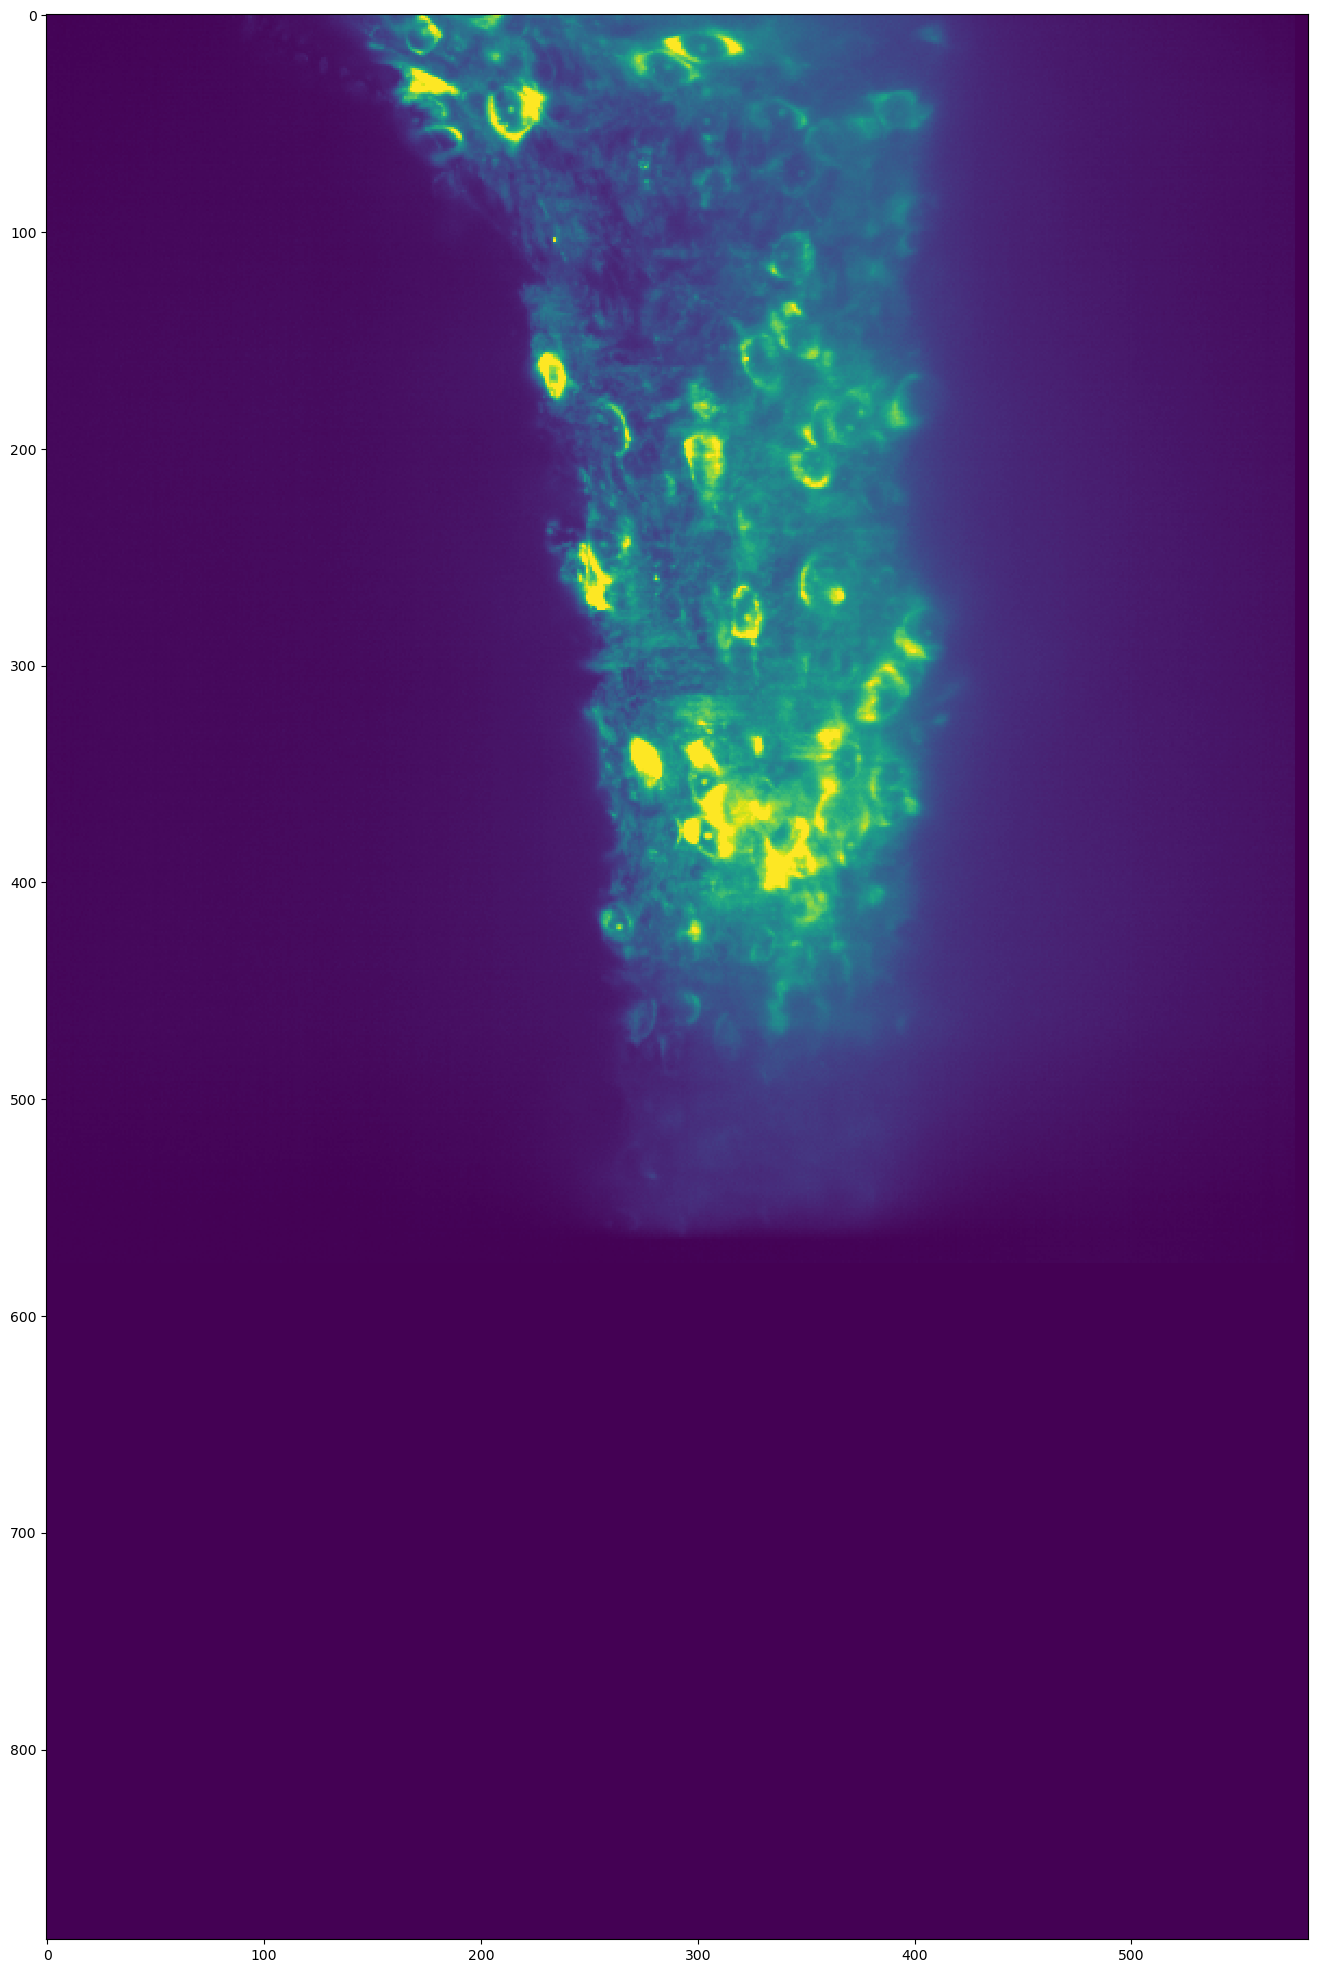

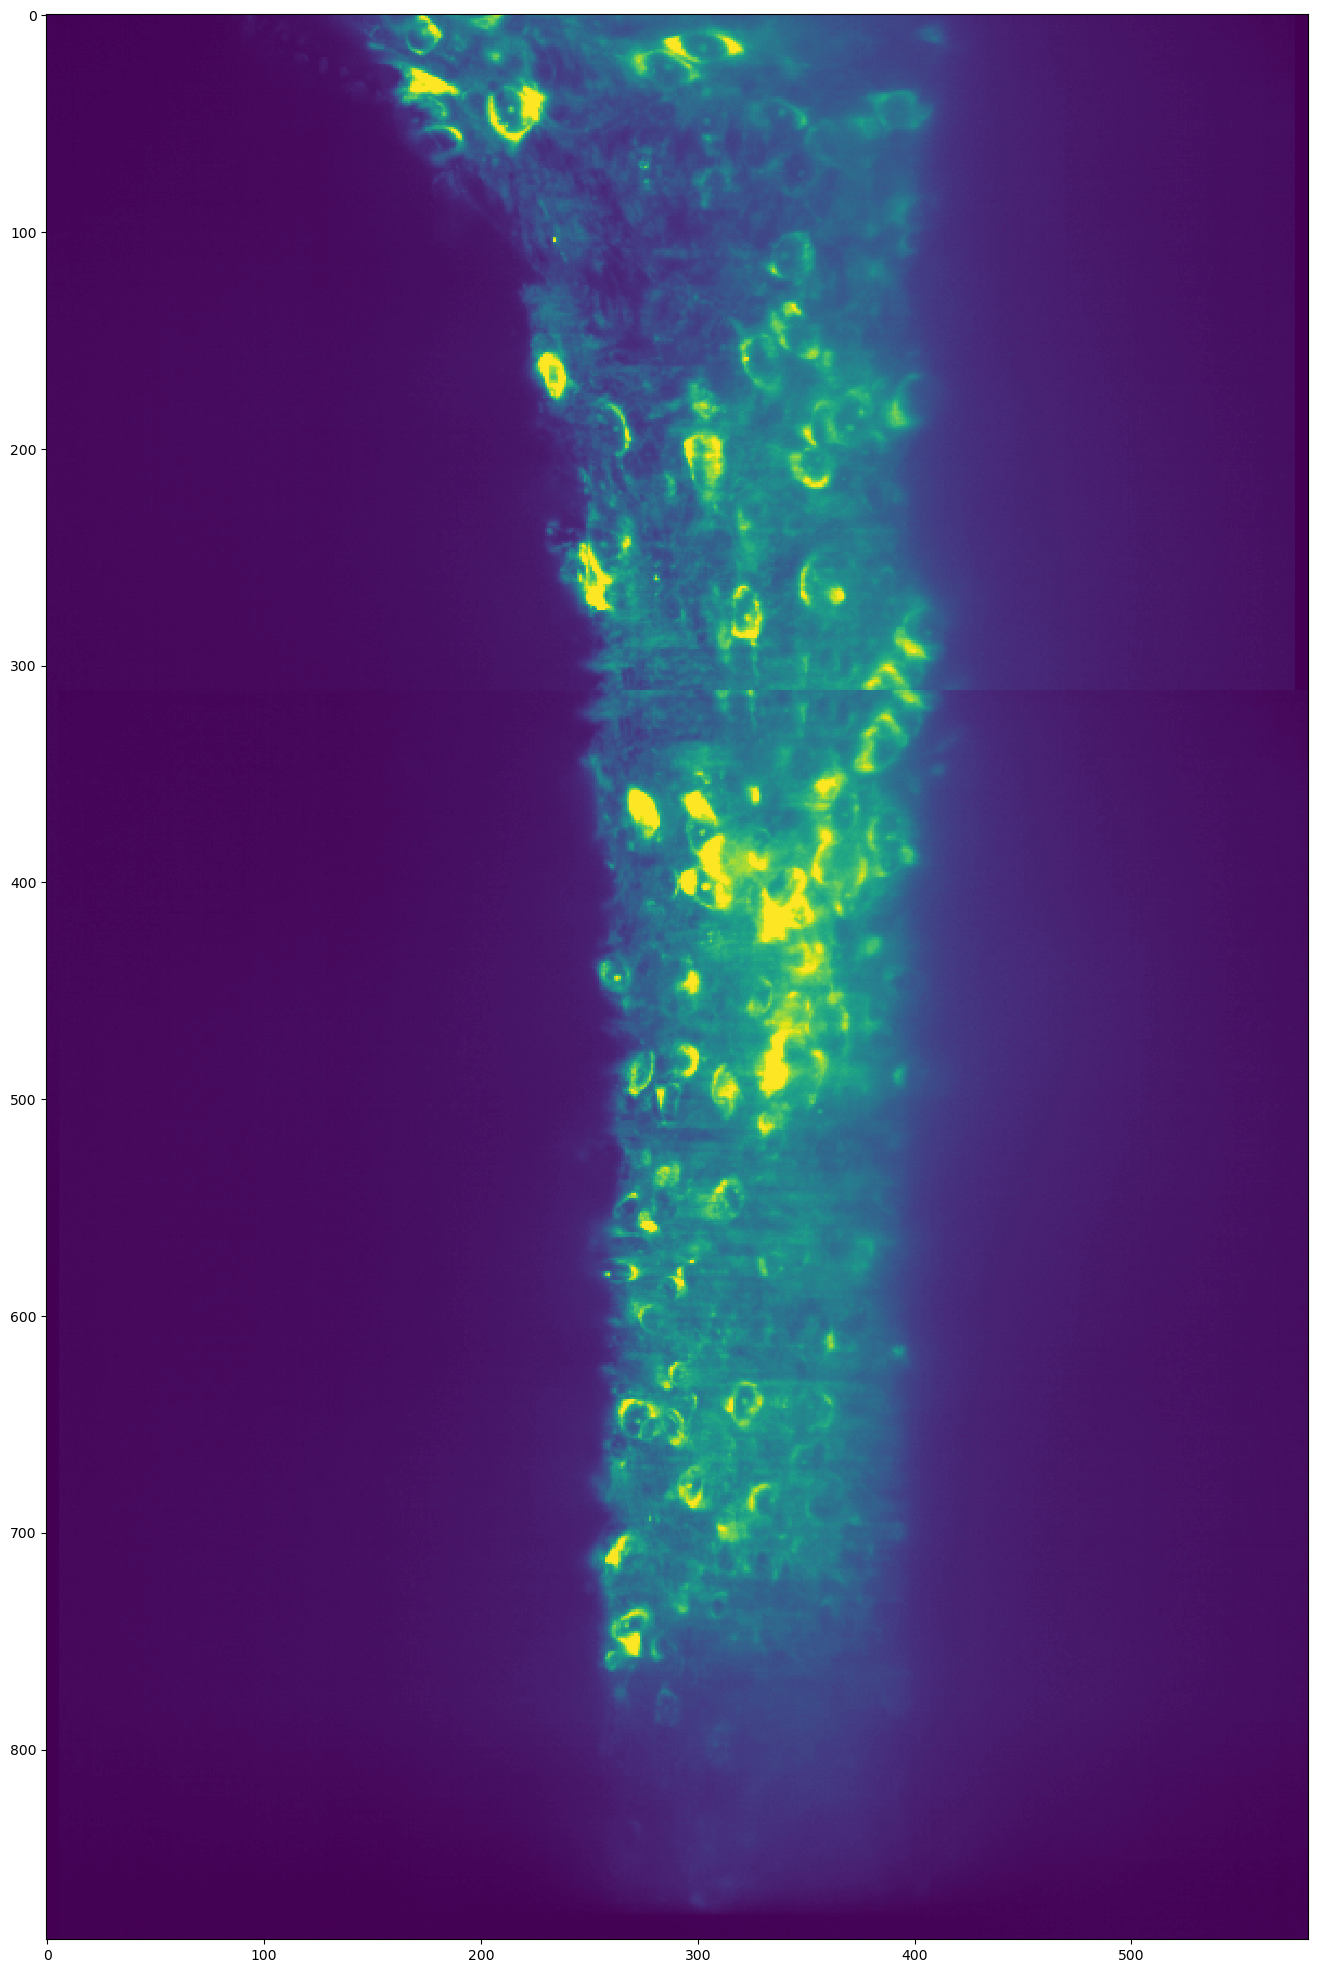

In [18]:
# Visualization
tile_size_xyz = (576, 576, 3551)
solved = coarse_mesh
ox, oy, oz = [], [], []
for i in range(len(tile_volumes)):
    ty, tx = idx_to_coord[i]
    ox.append([solved[0, 0, ty, tx] + tile_size_xyz[0] * tx])
    oy.append([solved[1, 0, ty, tx] + tile_size_xyz[1] * ty])
    oz.append([solved[2, 0, ty, tx]])   # (Apparently, can compute phase correlation prior to nominal positioning)
ox = np.array(ox)
oy = np.array(oy)
oz = np.array(oz)

# This defines the tile positions in the global coordinate system, after
# the initial coarse optimization.
oxyz = np.array([ox, oy, oz]).T[0, ...]
eoffs = oxyz

ext_min, ext_max = np.min(eoffs, axis=0), np.max(eoffs, axis=0)
z = 700

canvas_x = int(np.ceil(ext_max[0] - ext_min[0] + tile_size_xyz[0]))
canvas_y = int(np.ceil(ext_max[1] - ext_min[1] + tile_size_xyz[1]))
canvas = np.zeros((canvas_y, canvas_x), dtype=np.uint8)
for i in range(0, len(tile_volumes)):
    z0 = int(z - eoffs[i, 2])
    if z0 < 0 or z0 >= 1441:
        print(i, z0)
        continue

    ty, tx = idx_to_coord[i]

    x0 = int(np.ceil(eoffs[i, 0] - ext_min[0]))
    y0 = int(np.ceil(eoffs[i, 1] - ext_min[1]))
    sec = tile_volumes[i][:, :, z0]
    canvas[y0:y0+sec.shape[1], x0:x0+sec.shape[0]] = sec.T

    plt.figure(figsize=(20, 25))
    plt.imshow(canvas, interpolation='nearest')

In [11]:
# Run Fine Registration

# As opposed to .result() the entire tensorstore, 
# this splices the tensorstore, then .result() under numpy syntax.
class SyncAdapter:
  """Makes it possible to use a TensorStore objects as a numpy array."""
  def __init__(self, tstore, i):
    self.tstore = tstore
    self.i = i

  def __getitem__(self, ind):
    print(ind)
    return np.array(self.tstore[ind])

  def __getattr__(self, attr):
    return getattr(self.tstore, attr)

  @property
  def shape(self):
    return self.tstore.shape

  @property
  def ndim(self):
    return self.tstore.ndim

In [12]:
path_0 = f'preprocessed_0.zarr'
path_1 = f'preprocessed_1.zarr'
tile_0 = zarr_io.open_zarr(bucket, path_0)
tile_1 = zarr_io.open_zarr(bucket, path_1)

# Existing data structures:
tile_layout = np.array([[0], 
                        [1]])
idx_to_coord = {0:(0, 0), 1:(1, 0)}


# Must load in 4 dimensions: 1zyx shape
tile_volumes = [tile_0[0,:,:,:,:].resize(exclusive_max=(1, 3544, 576, 576)).result(), 
                tile_1[0,:,:,:,:]]

# Replacing 'tile_map' with SyncAdapter objects and adopting reverse basis
tile_map = {(0, 0): SyncAdapter(tile_volumes[0], 0), (0, 1): SyncAdapter(tile_volumes[1], 1)}
# Different basis
idx_to_coord = {0:(0, 0), 1:(0, 1)}


In [13]:
print(tile_volumes[0].shape)
print(tile_volumes[0].domain)
print(tile_volumes[0].shape == tile_volumes[1].shape)
print(tile_volumes[0].domain == tile_volumes[1].domain)

(1, 3544, 576, 576)
{ [0, 1*), [0, 3544*), [0, 576*), [0, 576*) }
True
True


In [14]:
# Fine Registration, compute patch flows
stride = 20, 20, 20
tile_size_xyz = (576, 576, 3544)  # Yet it expects the tiles as 1zyx...
flow_x, offsets_x = stitch_elastic.compute_flow_map3d(tile_map,
                                                      tile_size_xyz, cx, axis=0,
                                                      stride=stride,
                                                      patch_size=(80, 80, 80))
print(flow_x)
print(offsets_x)

flow_y, offsets_y = stitch_elastic.compute_flow_map3d(tile_map,
                                                      tile_size_xyz, cy, axis=1,
                                                      stride=stride,
                                                      patch_size=(80, 80, 80))

print(flow_y)
print(offsets_y)

np.savez_compressed('flow_results_st20_test2.npz', flow_x=flow_x, flow_y=flow_y, offsets_x=offsets_x, offsets_y=offsets_y)

{}
{}
(slice(None, None, None), slice(0, 3544, None), slice(300, 576, None), slice(0, 576, None))
(slice(None, None, None), slice(0, 3544, None), slice(0, 276, None), slice(0, 576, None))
{(0, 0): array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,      

- CPU: Does not finish in 2 hours
- JAX GPU, uint16: 1.7 minutes
- JAX GPU, uint8: 1.6 minutes -- not much optimization here

In [19]:
# Fine Registration, filter patch flows
kwargs = {"min_peak_ratio": 1.4, "min_peak_sharpness": 1.4, "max_deviation": 5, "max_magnitude": 0, "dim": 3}
fine_x = {k: flow_utils.clean_flow(v, **kwargs) for k, v in flow_x.items()}
fine_y = {k: flow_utils.clean_flow(v, **kwargs) for k, v in flow_y.items()}

kwargs = {"min_patch_size": 10, "max_gradient": -1, "max_deviation": -1}
fine_x = {k: flow_utils.reconcile_flows([v], **kwargs) for k, v in fine_x.items()}
fine_y = {k: flow_utils.reconcile_flows([v], **kwargs) for k, v in fine_y.items()}

# Caution here, proper variable is not tile_map
# redo_x = []
# for k, v in fine_x.items():
#   if np.all(np.isnan(v)):
#     print(k, tile_map[k[::-1]])
#     redo_x.append(k)

# redo_y = []
# for k, v in fine_y.items():
#   if np.all(np.isnan(v)):
#     print(k, tile_map[k[::-1]])
#     redo_y.append(k)

In [27]:
redo_x = []
for k, v in fine_x.items():
  if np.all(np.isnan(v)):
    print(k, tile_map[k])
    redo_x.append(k)

redo_y = []
for k, v in fine_y.items():
  if np.all(np.isnan(v)):
    print(k, tile_map[k])
    redo_y.append(k)

print(redo_x)
print(redo_y)

[]
[]


In [23]:
# Fine Registration, update mesh (convert coarse tile mesh into fine patch mesh)
data_x = (cx[:, 0, ...], fine_x, offsets_x)
data_y = (cy[:, 0, ...], fine_y, offsets_y)

fx, fy, init_x, nbors, key_to_idx = stitch_elastic.aggregate_arrays(
    data_x, data_y, list(tile_map.keys()),
    coarse_mesh[:, 0, ...], stride=stride, tile_shape=tile_size_xyz[::-1])

@jax.jit
def prev_fn(x):
  target_fn = ft.partial(stitch_elastic.compute_target_mesh, x=x, fx=fx, fy=fy, stride=stride)
  x = jax.vmap(target_fn)(nbors)
  return jnp.transpose(x, [1, 0, 2, 3, 4])

config = mesh.IntegrationConfig(dt=0.001, gamma=0., k0=0.01, k=0.1, stride=stride,
                                num_iters=1000, max_iters=20000, stop_v_max=0.001,
                                dt_max=100, prefer_orig_order=False,
                                start_cap=0.1, final_cap=10., remove_drift=True)

x, ekin, t = mesh.relax_mesh(init_x, None, config, prev_fn=prev_fn, mesh_force=mesh.elastic_mesh_3d)

np.savez_compressed('solved_mesh_st20.npz', x=x, key_to_idx=key_to_idx)  # This 'x' is the solved patch mesh(es).

KeyError: (0, 1)

In [ ]:
# Error is related to a shift in --> direction, which is not defined. 
# (The example code does nothing about this).

# Also, try to parse the output expression of coarse registration. That's the culprit. 